In [1]:
# Install everything needed for training, augmentation, and evaluation
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install seaborn matplotlib scikit-learn
!pip install textblob==0.15.3 googletrans==4.0.0-rc1 textaugment


  Using cached textblob-0.15.3-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached googletrans-4.0.0rc1-py3-none-any.whl
  Using cached httpx-0.13.3-py3-none-any.whl.metadata (25 kB)
  Using cached idna-2.10-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached h2-3.2.0-py2.py3-none-any.whl.metadata (32 kB)
  Using cached hyperframe-5.2.0-py2.py3-none-any.whl.metadata (7.2 kB)
  Using cached hpack-3.0.0-py2.py3-none-any.whl.metadata (7.0 kB)
Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)
Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
Using cached h2-3.2.0-py2.py3-none-any.whl (65 kB)
Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
Using cached hpack-3.0.0-py2.py3-none-any.whl (38 kB)
Using cached hyperframe-5.2.0-py2.py3-none-any.whl 

📦 Installing Required Packages

Before starting model training or evaluation, we need to install several libraries. These include HuggingFace's transformers for accessing pre-trained models, datasets for loading standard NLP datasets, and evaluate for performance metrics. We also include accelerate for efficient multi-GPU training, peft for Parameter-Efficient Fine-Tuning (like LoRA), and trl for advanced reinforcement learning tasks. Additionally, bitsandbytes is useful for 8-bit model optimization, helping to reduce memory consumption. Other helpful libraries include seaborn, matplotlib, and scikit-learn for plotting and classical ML tools. Lastly, textblob, googletrans, and textaugment support text preprocessing and augmentation.

🧼 Handling Numpy Version Mismatch & Ensuring Compatibility

Sometimes, version mismatches (especially with numpy) can break dependencies in notebook environments. This block ensures a clean slate by upgrading numpy and reinstalling critical libraries like pandas, matplotlib, scikit-learn, and transformers. Using --force-reinstall and --no-cache-dir helps avoid caching issues.

In [2]:
# 🧹 Full one-cell patch for numpy binary mismatch
!pip install --upgrade numpy
!pip install --force-reinstall --no-cache-dir \
    pandas matplotlib scikit-learn transformers evaluate \
    textaugment gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 158.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 180.1 MB/s eta 0:00:

🧠 Importing Core Libraries and Setting Seeds

In this block, we import essential Python libraries for data handling (pandas, numpy), plotting (matplotlib), NLP (datasets, transformers), metrics (sklearn), and text augmentation (textaugment). We also define a random seed for reproducibility and select the device (GPU if available, otherwise CPU). This setup is foundational for consistent training results and smooth data processing.

In [2]:
import os, torch, random, re, pandas as pd, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import (
    RobertaTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback
)
from sklearn.metrics import accuracy_score, classification_report
from peft import LoraConfig, get_peft_model, TaskType
import torch.nn as nn
from textaugment import EDA

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


📚 Downloading NLTK Resources

To support certain NLP tasks like tokenization and synonym replacement, we download key resources from the NLTK package. These include:

'punkt': a pre-trained tokenizer

'wordnet': a lexical database for synonyms

'stopwords': common words like “the”, “is”, etc.

'omw-1.4': Open Multilingual Wordnet, extending WordNet coverage.

The code also handles SSL certificate issues, which can occur in notebook environments while downloading datasets.

In [3]:
import nltk, ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except AttributeError:
    pass

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

📰 Loading and Augmenting AG News Dataset

In this section, we load the AG News dataset using HuggingFace’s datasets library. We first apply basic text cleaning: removing non-word characters and excess whitespace. Then, to improve generalization and help the model learn varied phrasing, we apply Easy Data Augmentation (EDA) on 10% of the training set using synonym replacement. The original and augmented data are combined to form a new, richer dataset. Finally, we convert the Pandas DataFrame back into a HuggingFace Dataset object for downstream tasks.

In [4]:
# Load AG News dataset
dataset = load_dataset("ag_news")

# Clean text to normalize punctuation and whitespace
def clean_text(example):
    text = re.sub(r"[^\w\s.,!?]", "", example["text"])
    text = re.sub(r"\s+", " ", text).strip()
    example["text"] = text
    return example

dataset = dataset.map(clean_text)
df_full = pd.DataFrame(dataset["train"]).drop_duplicates("text").reset_index(drop=True)

# EDA: Apply synonym replacement to 10% of training data
eda = EDA()
eda_sample = df_full.sample(frac=0.1, random_state=SEED)
eda_df = pd.DataFrame({
    "text": [eda.synonym_replacement(t) for t in eda_sample["text"]],
    "label": eda_sample["label"].tolist()
})

# Combine original + augmented data
df_combined = pd.concat([df_full, eda_df], ignore_index=True)
dataset = Dataset.from_pandas(df_combined)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

✂️ Tokenizing and Splitting the Dataset

In this section, we tokenize the cleaned and augmented dataset using RoBERTa’s tokenizer. The preprocess function truncates or pads each sequence to a maximum length of 192 tokens. After tokenization, we rename the "label" column to "labels" to comply with HuggingFace's Trainer API. We also convert the dataset into PyTorch format with essential inputs (input_ids, attention_mask, labels). Then, we split the dataset into training (80%), validation (10%), and test (10%) sets. Finally, a DataCollatorWithPadding is initialized to dynamically pad batches during training.


In [5]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=192)

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Split into train (80%), val (10%), test (10%)
split_1 = dataset.train_test_split(test_size=0.2, seed=SEED)
split_2 = split_1["test"].train_test_split(test_size=0.5, seed=SEED)
train_dataset = split_1["train"]
val_dataset = split_2["train"]
test_dataset = split_2["test"]
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/131897 [00:00<?, ? examples/s]

⚙️ Loading the Base Model and Applying LoRA

We load the base roberta-base model for sequence classification with 4 output labels. Instead of fine-tuning the full model, we apply LoRA (Low-Rank Adaptation) using peft. LoRA adds trainable adapters to certain attention layers, significantly reducing training time and GPU memory usage. In this config, we target three key layers of the RoBERTa encoder. This approach allows efficient fine-tuning while keeping most of the original model frozen.

In [6]:
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16, lora_alpha=32, lora_dropout=0.1, bias="none",
    target_modules=[
        "roberta.encoder.layer.10.attention.self.query",
        "roberta.encoder.layer.11.attention.self.query",
        "roberta.encoder.layer.11.output.dense"
    ]
)

model = get_peft_model(base_model, lora_config).to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Defining Evaluation Metrics and Focal Loss Trainer

We define a custom compute_metrics function to calculate accuracy and per-class F1 scores using sklearn. This helps evaluate model performance in a more granular way across the four AG News categories. Additionally, we subclass HuggingFace’s Trainer to override the loss function. Instead of plain cross-entropy, we use Focal Loss, which down-weights easy examples and focuses training on harder, misclassified ones — especially useful in imbalanced datasets.

In [7]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True, target_names=label_names)
    results = {"eval_accuracy": acc}
    for cname in label_names:
        results[f"{cname}_f1"] = report[cname]["f1-score"]
    return results

class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        ce_loss = nn.CrossEntropyLoss(reduction="none")(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** 2 * ce_loss).mean()
        return (focal_loss, outputs) if return_outputs else focal_loss


🚫 Disabling WandB Logging

Weights & Biases (WandB) is often integrated by default with the HuggingFace Trainer. This block disables WandB entirely to avoid logging overhead or if you are not using it for experiment tracking.

In [8]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"


📉 Custom Callback for Logging Training Loss\

This section defines a custom TrainerCallback named LossLogger. It logs the training loss every n steps (default is 100) during training. This helps monitor convergence behavior in real-time, even if you're not using tools like TensorBoard or WandB.

In [9]:
class LossLogger(TrainerCallback):
    def __init__(self, log_every=100):
        self.log_every = log_every
        self.losses = []

    def on_step_end(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            step = state.global_step
            if step % self.log_every == 0:
                loss = logs["loss"]
                self.losses.append((step, loss))
                print(f"📝 Step {step} - Training Loss: {loss:.4f}")


⚙️ Set Up Training Configuration and Initialize Custom Trainer (with Focal Loss)

This block defines the training configuration using TrainingArguments, specifying key hyperparameters such as learning rate, batch size, and logging options. Then, we initialize a custom FocalLossTrainer—a subclass of Hugging Face’s Trainer—designed to incorporate Focal Loss to better handle class imbalance. It also includes a custom LossLogger callback to track training loss during execution.

In [10]:
training_args = TrainingArguments(
    output_dir="lora_agnews_final",
    num_train_epochs=1,  # we'll handle loop manually
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=3e-4,
    weight_decay=0.02,
    logging_dir="./logs",
    logging_steps=100,
    seed=SEED,
    report_to="none"
)

trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[LossLogger(log_every=100)]
)


<ipython-input-10-ce7bdae92f6b>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalLossTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalLossTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🔁 Manual Training Loop with Model Checkpointing
We manually loop through training epochs to track validation accuracy. If the accuracy improves, we save the current model as best_model.

In [11]:
best_acc = 0
val_accs = []
epochs = 5

for epoch in range(epochs):
    print(f"\n🟢 Training Epoch {epoch + 1}/{epochs}")
    trainer.train()
    val_metrics = trainer.evaluate(eval_dataset=val_dataset)
    val_acc = val_metrics["eval_accuracy"]
    val_accs.append(val_acc)
    print(f"📊 Validation Accuracy: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        trainer.save_model("best_model")



🟢 Training Epoch 1/5


Step,Training Loss
100,0.476400
200,0.151900
300,0.144300
400,0.134200
500,0.138200
600,0.142700
700,0.135300
800,0.114800
900,0.134400
1000,0.128500


📊 Validation Accuracy: 0.9272

🟢 Training Epoch 2/5


Step,Training Loss
100,0.094600
200,0.079600
300,0.091500
400,0.097500
500,0.087000
600,0.108400
700,0.097500
800,0.076200
900,0.101500
1000,0.106300


📊 Validation Accuracy: 0.9309

🟢 Training Epoch 3/5


Step,Training Loss
100,0.083100
200,0.073400
300,0.084300
400,0.090900
500,0.078700
600,0.097100
700,0.082900
800,0.068700
900,0.092700
1000,0.094400


📊 Validation Accuracy: 0.9318

🟢 Training Epoch 4/5


Step,Training Loss
100,0.073500
200,0.072200
300,0.076300
400,0.080900
500,0.076600
600,0.094600
700,0.081600
800,0.064900
900,0.097400
1000,0.098400


📊 Validation Accuracy: 0.9337

🟢 Training Epoch 5/5


Step,Training Loss
100,0.073300
200,0.056000
300,0.076800
400,0.077300
500,0.074400
600,0.080500
700,0.068000
800,0.064100
900,0.091600
1000,0.086000


📊 Validation Accuracy: 0.9363


📈 Predict on Test Dataset and Compute Class Probabilities

After training, we evaluate the model on the test set. We convert logits to softmax probabilities and extract the predicted class and true labels.

In [17]:
predictions = trainer.predict(test_dataset)
y_logits = predictions.predictions
y_probs = torch.nn.functional.softmax(torch.tensor(y_logits), dim=-1).numpy()  # class probabilities
y_pred = y_probs.argmax(axis=1)  # predicted class
y_true = predictions.label_ids  # true labels


🧪 Precision-Recall Curves for Each Class

We plot precision-recall curves in a one-vs-rest fashion for each of the 4 classes to better understand performance under different thresholds.

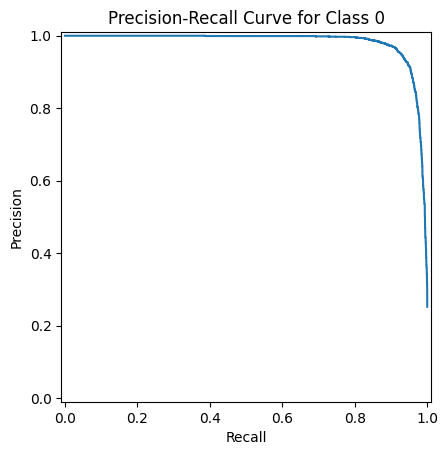

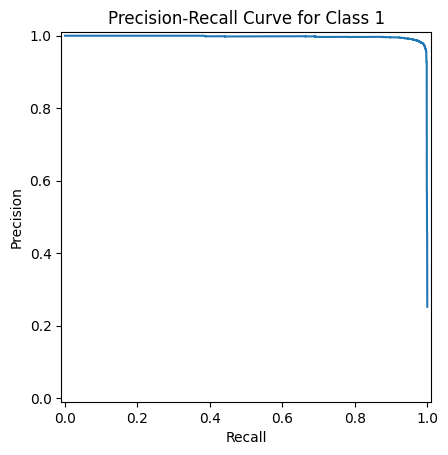

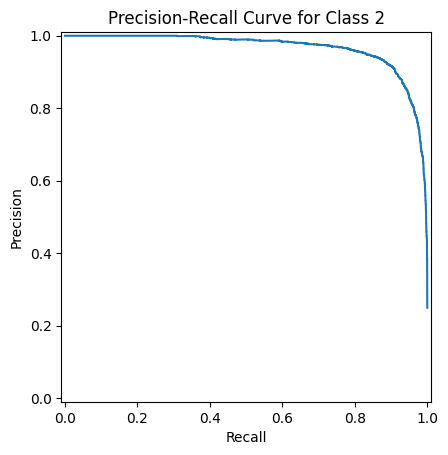

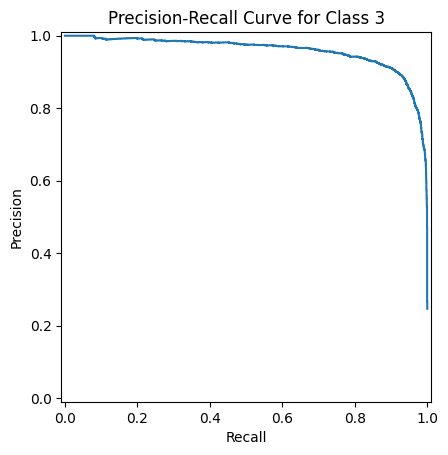

In [18]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay

# Binarize labels for one-vs-rest multi-class precision-recall
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

for i in range(y_probs.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for Class {i}')
    plt.show()


📊 Evaluate on Test Set and Visualize Confusion Matrix

This block evaluates predictions on the test set and plots a confusion matrix to visualize misclassifications between the 4 classes.

<Figure size 800x600 with 0 Axes>

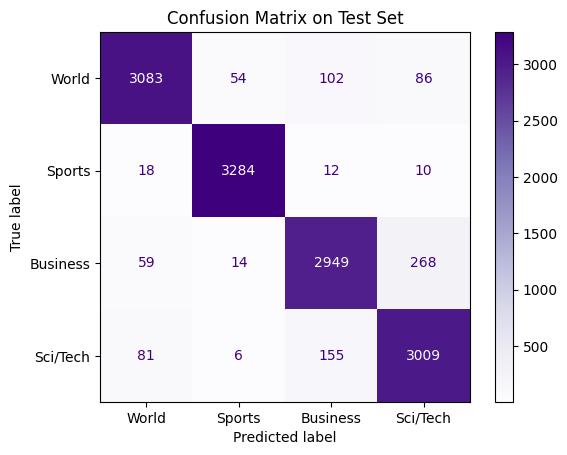

In [12]:
# ✅ Evaluate on test set and plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🧪 Predict on test set
test_output = trainer.predict(test_dataset)
y_true = test_output.label_ids
y_pred = test_output.predictions.argmax(-1)

# 📊 Confusion matrix
label_names = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Purples", values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()

✅ Final Evaluation on Test Set

We evaluate the final model on the test set and print the overall test accuracy. This gives a clear measure of how well the model generalizes.

In [13]:
print("\n🧪 Evaluating on Test Set...")
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
test_acc = test_metrics["eval_accuracy"]
print(f"🧪 Final Test Accuracy: {test_acc:.4f}")



🧪 Evaluating on Test Set...


🧪 Final Test Accuracy: 0.9344


📏 Count Total and Trainable Parameters

This function prints the total number of parameters in the model, how many are trainable, and how many are frozen. Useful for understanding model size and efficiency with LoRA.

In [14]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🔢 Total parameters: {total:,}")
    print(f"🛠️ Trainable parameters: {trainable:,}")
    print(f"🔒 Frozen parameters: {total - trainable:,}")
    return total, trainable

# Run this after model = get_peft_model(...)
count_parameters(model)


🔢 Total parameters: 125,352,968
🛠️ Trainable parameters: 704,260
🔒 Frozen parameters: 124,648,708


(125352968, 704260)

📈 Plot Validation Accuracy Across Epochs

We plot how validation accuracy changes across epochs to visualize learning progression. This can be saved for reports or presentations.

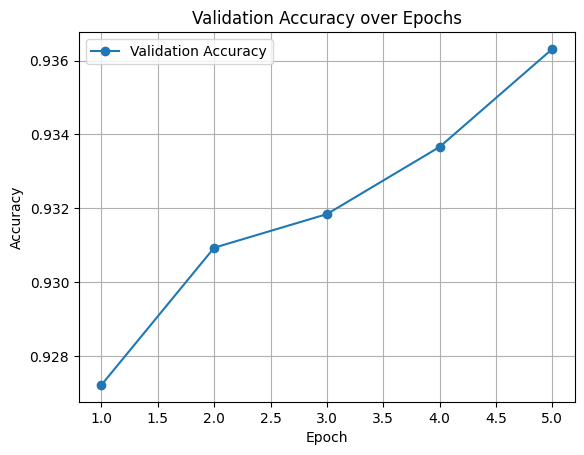

In [15]:
# Plot Validation Accuracy
plt.plot(range(1, len(val_accs)+1), val_accs, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.savefig("accuracy_plot.png")
plt.show()




📂 Load Unlabeled Test Data for Final Submission

This loads the test data (test_unlabelled.pkl) which doesn’t have labels and is used for submission predictions.

In [24]:
import pandas as pd

df_test_unlabelled = pd.read_pickle("test_unlabelled (1).pkl")


🔄 Tokenize Unlabeled Test Data

Tokenizes the final test data using the same RoBERTa tokenizer for consistency with training preprocessing.

In [26]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=192)

test_dataset = test_dataset.map(preprocess, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/13190 [00:00<?, ? examples/s]

💾 Load LoRA-Adapted Model from Disk

This loads the LoRA-tuned model from the saved checkpoint (best_model) and prepares it for inference.

In [28]:
from transformers import AutoModelForSequenceClassification
from peft import PeftModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load base model and LoRA-adapted model
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
model = PeftModel.from_pretrained(base_model, "best_model")
model.eval().to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-9): 10 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=Fals

🔍 Predict on Final Unlabeled Test Set

Performs inference on the final test set using the loaded model and stores the predictions.

In [29]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

loader = DataLoader(test_dataset, batch_size=32)
predictions = []

with torch.no_grad():
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        predictions.extend(preds.cpu().numpy())

100%|██████████| 413/413 [01:51<00:00,  3.70it/s]


🧾 Create Submission CSV File

Maps numeric labels to class names, constructs a submission DataFrame, and writes it to a CSV file.

In [30]:
import pandas as pd

label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
pred_labels = [label_map[p] for p in predictions]

submission_df = pd.DataFrame({
    "ID": list(range(len(predictions))),
    "label": predictions
})

submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv created with", len(predictions), "rows.")

✅ submission.csv created with 13190 rows.
